Creates a Depth image for the model's predictions only, made by different kind of synthetic depth images combination.

In [1]:
import os
import numpy as np
from numpy import ones,vstack
from numpy.linalg import lstsq
%matplotlib inline 
from matplotlib import pyplot as plt
import cv2
import cairo
import math
from scipy import ndimage, misc
import matplotlib

Constants

In [2]:
result_depth_image_file_name = 'depth_image_to_use_for_predictions.png'
min_color = 0
max_color = 256
depth_images_folder = "depth/"
final_depth_image_weights = {"frame_to_center": 0.0,
                             "ellipses_around_image_center": 0.0,
                             "images_average": 0.9,
                             "random": 0.1}

In [3]:
image_shape = cv2.imread(os.path.join(os.getcwd(), depth_images_folder + "0.png"), 0).shape
image_width = image_shape[1]
image_height = image_shape[0]

Frame to image center lines.

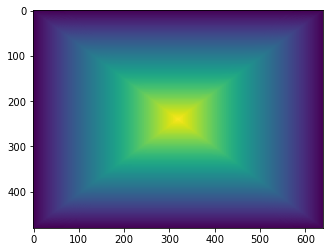

In [4]:
def get_line(x1, y1, x2, y2):
    points = []
    issteep = abs(y2-y1) > abs(x2-x1)
    if issteep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    rev = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        rev = True
    deltax = x2 - x1
    deltay = abs(y2-y1)
    error = int(deltax / 2)
    y = y1
    ystep = None
    if y1 < y2:
        ystep = 1
    else:
        ystep = -1
    for x in range(x1, x2 + 1):
        if issteep:
            points.append((y, x))
        else:
            points.append((x, y))
        error -= deltay
        if error < 0:
            y += ystep
            error += deltax
    # Reverse the list if the coordinates were reversed
    if rev:
        points.reverse()
    return points

def get_depth_image__synthetic_image_frame_to_center(image_width, image_height):
    center_point_x = int(image_width / 2)
    center_point_y = int(image_height / 2)
    lines_start_points = []
    for i in range(image_width):
        lines_start_points.append((i, 0))
        lines_start_points.append((i, image_height - 1))
    for i in range(image_height):
        lines_start_points.append((0, i))
        lines_start_points.append((image_width - 1, i))
    synthetic_depth_image = np.zeros(shape=(image_height, image_width), dtype=np.int16)
    for line_start_point in lines_start_points:
        line_points = get_line(x1=line_start_point[0], y1=line_start_point[1], x2=center_point_x, y2=center_point_y)
        for j in range(len(line_points)):
            point = line_points[j]
            synthetic_depth_image[point[1]][point[0]] = min_color + int((abs(j) / len(line_points)) * (max_color - min_color))
    return synthetic_depth_image

frame_to_center_depth_image = get_depth_image__synthetic_image_frame_to_center(image_width=image_width, image_height=image_height)
plt.imshow(frame_to_center_depth_image, interpolation='nearest')
plt.show()

Ellipses around the image's center.

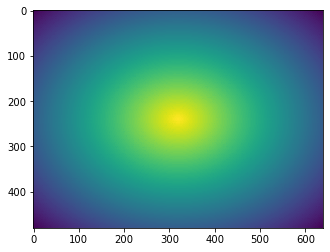

In [5]:
def get_synthetic_depth_image__ellipses_around_image_center(image_width, image_height):
    max_size = max(image_width, image_height)
    image_width_, image_height_ = 2 * max_size, 2 * max_size
    center_point_x = int(image_width_ / 2)
    center_point_y = int(image_height_ / 2)
    synthetic_depth_image = np.zeros((image_height_, image_width_, 4), dtype=np.uint8)
    surface = cairo.ImageSurface.create_for_data(
        synthetic_depth_image, cairo.FORMAT_ARGB32, image_height_, image_width_)
    cr = cairo.Context(surface)
    cr.set_source_rgb(0.0, 0.0, 0.0)
    cr.paint()
    corner_to_center_length = int(np.linalg.norm(np.array([image_height_, image_width_])))
    for j in range(corner_to_center_length):
        cr.arc(center_point_y, center_point_x, j, 0, 2 * math.pi)
        cr.set_line_width(2)
        color = 1.0 - (min_color + int((abs(j) / corner_to_center_length) * (max_color - min_color))) / max_color
        cr.set_source_rgb(color, color, color)
        cr.stroke()
    return cv2.resize(synthetic_depth_image[:,:,0], (image_width, image_height))

ellipses_around_image_center_depth_image = get_synthetic_depth_image__ellipses_around_image_center(image_width=image_width, image_height=image_height)
plt.imshow(ellipses_around_image_center_depth_image, interpolation='nearest')
plt.show()

Dataset's Depth images average.

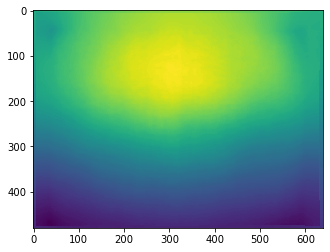

In [6]:
def get_depth_image__images_average(path):
    depth_abs_fnames = [os.path.join(path, f) for f in os.listdir(path)]
    sum_depth_image = np.zeros(shape=(image_height, image_width), dtype=np.float64)
    for i, fname in enumerate(depth_abs_fnames):
        sum_depth_image = np.add(sum_depth_image, cv2.imread(fname, 0))
    return (sum_depth_image / len(depth_abs_fnames)).astype(int)

average_depths_images_depth_image = get_depth_image__images_average(path=os.path.join(os.getcwd(), depth_images_folder))
plt.imshow(average_depths_images_depth_image, interpolation='nearest')
plt.show()

Random depth

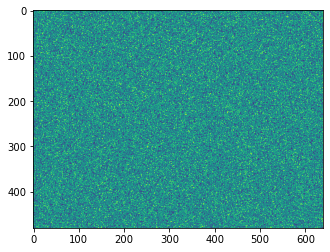

In [7]:
def get_synthetic_depth_image__random(image_width, image_height):
    return (np.random.uniform(low=0, high=1, size=(image_height, image_width)) * (max_color - min_color)).astype(int)

random_depth_image = get_synthetic_depth_image__random(image_width=image_width, image_height=image_height)
plt.imshow(random_depth_image)
plt.show()

Combination of the above depth images, by weights map.

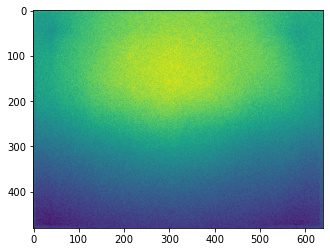

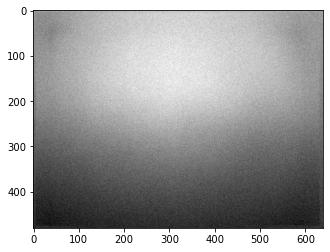

In [8]:
frame_to_center_depth_image_weighted = frame_to_center_depth_image.astype(np.float32) * final_depth_image_weights["frame_to_center"]
ellipses_around_image_center_depth_image_weighted = ellipses_around_image_center_depth_image.astype(np.float32) * final_depth_image_weights["ellipses_around_image_center"]
average_depths_images_depth_image_weighted = average_depths_images_depth_image.astype(np.float32) * final_depth_image_weights["images_average"]
random_depth_image_weighted = random_depth_image.astype(np.float32) * final_depth_image_weights["random"]
depth_image_to_use_for_predictions = np.zeros(shape=(image_height, image_width), dtype=np.float64)
depth_image_to_use_for_predictions = np.add(depth_image_to_use_for_predictions, frame_to_center_depth_image_weighted)
depth_image_to_use_for_predictions = np.add(depth_image_to_use_for_predictions, ellipses_around_image_center_depth_image_weighted)
depth_image_to_use_for_predictions = np.add(depth_image_to_use_for_predictions, average_depths_images_depth_image_weighted)
depth_image_to_use_for_predictions = np.add(depth_image_to_use_for_predictions, random_depth_image_weighted)
depth_image_to_use_for_predictions = depth_image_to_use_for_predictions.astype(np.int16)

plt.imshow(depth_image_to_use_for_predictions)
plt.show()
plt.imsave(result_depth_image_file_name, depth_image_to_use_for_predictions, format='png', cmap=matplotlib.cm.gray)
plt.imshow(depth_image_to_use_for_predictions, cmap=matplotlib.cm.gray)
plt.show()